In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def get_data(is_MNIST):
    if is_MNIST:
        mnist = tf.keras.datasets.mnist 
        (x_mnist_train, y_mnist_train), (x_mnist_test, y_mnist_test) = mnist.load_data()
        x_mnist_train, x_mnist_test = x_mnist_train / 255.0, x_mnist_test / 255.0
        train_images = x_mnist_train.reshape((60000, 28, 28, 1)).astype(np.float32)
        train_labels = y_mnist_train.reshape((60000, 1))
        test_images = x_mnist_test.reshape((10000, 28, 28, 1)).astype(np.float32)
        test_labels = y_mnist_test.reshape((10000, 1))
        in_L = 28
        in_c = 1
    else:
        cifar10 = tf.keras.datasets.cifar10 
        (X, Y), (X_test, Y_test) = cifar10.load_data()
        train_images = (X/255.0).astype(np.float32); test_images = (X_test/255).astype(np.float32)
        train_labels = Y; test_labels = Y_test
        in_L = 32
        in_c = 3
    return train_images, train_labels, test_images, test_labels, in_L, in_c


def train(model, data_set, batch_size=64, epochs=1, verbose=0):
    train_images, train_labels, test_images, test_labels, in_L, in_c = data_set
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    model.fit(train_images, train_labels, epochs=epochs, batch_size=batch_size, validation_data=(test_images, test_labels),
              verbose=verbose)
    return model

def build_model(Layer, is_MNIST):
    if is_MNIST:
        in_L = 28; in_c=1
    else:
        in_L = 32; in_c=3
    '''
     MNIST用に前回作ったネットワークの3層目に任意レイヤー
    '''
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(in_L, in_L, in_c)))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(Layer())
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))    
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))
    #model.summary()
    return model

def see_attns(x, model, L_atten, in_L, in_c, T=0.1, queries=None, N_plots = 5, markers= ['o', '*', 'D', ',', '^']):
    fig = plt.figure(figsize=(14,4))
    fig.add_subplot(1, N_plots+2, 1)
    if in_c==1:
        plt.imshow(x.reshape(in_L, in_L), cmap = "gray")
    else:
        plt.imshow(x.reshape(in_L, in_L, in_c))
    for l in range(L_atten):
        x = model.layers[l](x)
    attnmap = model.layers[L_atten].attn_map(x, T=T)
    L = x.shape[1]
    qs = []
    for i in range(N_plots):
        if not queries is None:
            query = queries[i]
        else:
            query = np.random.randint(L**2)
        qs.append(query)
        fig.add_subplot(1,N_plots+1,i+2)
        attn = attnmap[0,0,:,query]
        fig.axes[i+1].set_title("Attn({}, K)".format(query))
        plt.imshow(attn.numpy().reshape(L, L), interpolation='gaussian', cmap='Blues_r')#, vmin = 0, vmax = 1)
        x = query%L
        y = (query-x)//L
        plt.scatter(x, y, color='#e6ffdc', marker=markers[i], edgecolors='green')
        fig.axes[0].scatter(x*in_L/L, y*in_L/L, color='#e6ffdc', marker=markers[i], edgecolors='green')
    plt.show()
    return qs

def random_sample(train_images, in_L, in_c):
    i = np.random.randint(10000)
    x = train_images[i].reshape(1, in_L, in_L, in_c)
    return x

## 5-3. アテンション機構

最後に紹介したい近年のテクニックが **注意機構(attention mechanism)** と呼ばれるものです。これは大雑把に言うとデータや特徴量のどの部分に注目すべきかを数式化したもので、近年の深層学習において重要な道具となってきていると同時に、興味深い研究対象でもあると思います。特に自然言語処理では注意機構は [arXiv:1706.03762](https://arxiv.org/abs/1706.03762) において提唱されたモデル、**Transformer** にて中心的な役割を担っており、ここ数年で一気に自然言語処理のデファクトスタンダードになってきた感じがします。ここではアテンションを使った自然言語処理の実装やデモは時間の都合上お見せできませんが、気になる方は tensorflowのチュートリアル等で実際に動かしながら学べるので、そちらを参照していただくと良いかと思います。

### 辞書オブジェクト
突然ですが、pythonには辞書オブジェクトというのがあります。実はアテンション機構は辞書オブジェクトのようなものだと考えるとしっくり来るのです。pythonにおける辞書オブジェクトはこんなものです：


In [4]:
dict1 = {'small':50, 'medium':200, 'large':500}

辞書オブジェクトは、
* keys: 値を呼び出すのに必要な「鍵」
* values: 呼び出したい「値」

から成るオブジェクトで、それぞれの属性は

In [5]:
print(dict1.keys())
print(dict1.values())

dict_keys(['small', 'medium', 'large'])
dict_values([50, 200, 500])


のようにして確認できます。これをどのように使うかと言うと、例えばコーヒー豆の量り売りをしている業者がいるとして、注文は`small, medium, large` のいずれかで受け付ける、ということにしているとしましょう。このときの注文を
* query: どの値を呼び出したいかの「クエリ」

として実装すると、以下のようにして辞書オブジェクトから

In [6]:
query = 'small'
content = dict1[query]
content

50

のようにして、ほしい値を呼び出すことができます。このように、
* queryに合うkeyを探し、そのvalueをcontentとして返す

という処理を、機械学習のタスクでもモデルの内部に組み込むといい場合があります。深層ニューラルネットでこの処理を行うと考えられているのがアテンション機構です。アテンション機構は初めは翻訳などのタスクで用いられ始めましたが、辞書オブジェクトを深層学習に組み込む、というスローガンの下、最近では様々なケースに使われ始めています。

### ハード・アテンション

辞書オブジェクトの例で、全ての「鍵」を集めたものを ${\bf K}$、全ての「値」を集めたものを ${\bf V}$ と呼ぶことにし、それぞれの要素に番号を振ります。

$$
{\bf K} = [\underbrace{k_1}_{\text{small}}, \underbrace{k_2}_{\text{medium}}, \underbrace{k_2}_{\text{large}}]
\\
{\bf V} = [\underbrace{v_1}_{50}, \underbrace{v_2}_{200}, \underbrace{v_3}_{500}]
$$

ここに「クエリ」を投げ込んで、対応する値を取得するには

$$
f(\text{query}, \text{key}) = 
\left\{ \begin{array}{ll}
1 & \text{(if query = key)}
\\
0 & \text{(otherwise)}
\end{array} \right.
$$

という関数を作って、

$$
c = \sum_{i = 1}^3 f(\text{query}, k_i) v_i
$$

とすれば良いでしょう。これがアテンションの最もシンプルな形です。これは $f$ で「0か1か」とハードな(微分不可能な)形式になっていることから、**ハード・アテンション** と呼ばれます。つまり、辞書オブジェクトとその参照はハード・アテンションです。

#### ベクトル化
ここで、「鍵・値・クエリ」をすべてベクトルに置き換えても良いでしょう。更に鍵と値の数を任意の個数 $N_\text{attn}$ にしましょう。すると、

$$
{\bf K} = [{\bf k}_1, {\bf k}_2, \dots, {\bf k}_{N_\text{attn}}]
\\
{\bf V} = [{\bf v}_1, {\bf v}_2, \dots, {\bf v}_{N_\text{attn}}]
$$

となり、クエリもベクトル化して

$$
f({\bf q}, {\bf k}) = 
\left\{ \begin{array}{ll}
1 & \text{(if }{\bf q} = {\bf k})
\\
0 & \text{(otherwise)}
\end{array} \right.
$$


注意ですが、**${\bf k}, {\bf v}$ の次元は異なっていても良いですが、${\bf k}, {\bf q}$の次元は合っていないとだめです**。ベクトル化できたのでニューラルネットワークに組み込めそうな気がしてきました。

### ソフト・アテンション
深層学習に何かを組み込む一番素朴な方法は、その操作を「微分可能」にすることです。
> 実は微分不可能なハード・アテンションも様々な方法で訓練できます。たとえば後に強化学習の部分で紹介する**REINFORCE**アルゴリズムを用いるなどの代替案があり得ますが、ここでは割愛します。

上のハード・アテンションはクエリが鍵に厳密に合致したときのみ1で、それ以外は0なので、明らかに微分不可能になりそうです。そこで、

$$
f({\bf q}, {\bf k}) = 
\left\{ \begin{array}{ll}
\text{high} & \text{(if }{\bf q} \approx {\bf k})
\\
\text{low} & \text{(if }{\bf q} \not \approx {\bf k})
\end{array} \right.
$$

のような微分可能な確率値関数： $\sum_{i=1}^{N_{\text{attn}}} f({\bf q}, {\bf k}_i) = 1$ を取れば似た操作ができそうになってきました。そのような関数としてよく取られるのがsoftmax関数です。

$$
f({\bf q}, {\bf k}_i) = \sigma_\text{softmax} ({\bf q} \cdot {\bf k}_i) = \frac{e^{{\bf q} \cdot {\bf k}_i}}{\sum_{j=1}^{N_{\text{attn}}}e^{{\bf q} \cdot {\bf k}_j}}
$$

softmax関数の中身を積にとるか、和に取るか、スケール倍するか、非線形関数を通すか、等さまざまなバージョンがあり得ますが、ここでは後でデモンストレーションに使う**dot-product**アテンションと呼ばれるものを用いることにします。dot-productアテンションを図示すると以下のようになります：

![alt](attn1.jpg)

[5-2](#5-2-スキップ接続) でネットワークにスキップ構造を入れてもOKという話を紹介しましたが、上の図を見ると、この図そのものをニューラルネットワークの図の構成要素として使えそうな気がしてきます。実際、ニューラルネットワークにうまく上のような構造を入れ込むのがアテンション機構のやっていることなのです。

$$
{\bf c} = \sum_{i=1}^{N_{\text{attn}}} \sigma_\text{softmax}({\bf q}\cdot{\bf k}_i) {\bf v}_i
$$

この $\sigma_\text{softmax}({\bf q}\cdot{\bf k}_i)$ の確率は、クエリに対してどの鍵の割合を大きくするかを表しているので、後に見るように上手く深層ニューラルネットに組み込むことができると、ネットワークが「なにに注目しているか」の分布に対応します。




### 例 - 自己注意 
アテンションをニューラルネットワークに組み込むには、Key, Query, Valueの3つの入力をどう考えるかのセンスが問われるわけですが、難しいことは考えずに、最も素朴に

![alt](attn2.jpg)

をニューラルネットワークの1層の単位とすることができます。これを**自己注意(self-attention)** といいます。名前の意味は「自分自身から自分自身への注意」を向けているということです。

これは畳み込み演算でも同じことができます。クエリはせっかくなので、「全ピクセル」から飛ばしてみることにします。この構造は[arXiv:1805.08318](https://arxiv.org/abs/1805.08318)で使われたネットワークに由来します：

![alt](attn3.jpg)

この図にあるように、うまくいけばネットワークは入力ピクセル毎に、タスクを解く際に「どの部分に注目すべきか」を解くことができるようになります：







In [8]:
class SelfAttn(tf.keras.layers.Layer):
    def __init__(self):
        super(SelfAttn, self).__init__()
        
    def build(self, input_shape):
        in_Lx = input_shape[1]
        in_Ly = input_shape[2]
        in_channels = input_shape[3] # input_shape = (batchsize, Lx, Ly, channels), and input_shape[-1] = channels
        self.conv_key = tf.keras.layers.Conv2D(in_channels//2, (1,1), padding='same', input_shape = input_shape)
        self.conv_query = tf.keras.layers.Conv2D(in_channels//2, (1,1), padding='same', input_shape = input_shape)
        self.conv_value = tf.keras.layers.Conv2D(in_channels, (1,1), padding='same', input_shape = input_shape)        
        self.reshape_key_query = tf.keras.layers.Reshape((1, in_Lx*in_Ly, in_channels//2))
        self.reshape_value = tf.keras.layers.Reshape((in_channels, 1, in_Lx*in_Ly))
        self.reshape_final = tf.keras.layers.Reshape((in_Lx, in_Ly, in_channels))
    
    def attn_map(self, inputs, T=1):
        key = self.reshape_key_query(self.conv_key(inputs))             # (,1, LxLy_k, s)
        query = self.reshape_key_query(self.conv_query(inputs))         # (,1, LxLy_q, s)
        logit_attn = tf.linalg.matmul(a=key, b=query, transpose_b=True) # (,1, LxLy_k, LxLy_q)
        attn = tf.keras.activations.softmax(logit_attn/T, axis=2)
        return attn
  
    def attention(self, inputs):
        attn = self.attn_map(inputs)                        # (, 1,       LxLy_k, LxLy_q)
        value = self.reshape_value(self.conv_value(inputs)) # (, channel,      1, LxLy_v)
        out = tf.linalg.matmul(value, attn)                 # (, channel,      1, LxLy_q)
        out = tf.transpose(out, perm=[0,3,2,1])
        return self.reshape_final(out)

    def call(self, inputs):
        ''' Residual structure '''
        return inputs + self.attention(inputs)
    
x = tf.random.uniform(shape=[2, 28, 28, 3])
selfattn = SelfAttn()
selfattn(x).shape

TensorShape([2, 28, 28, 3])

実際に訓練してみて、きちんとピクセル毎のクエリに対して特徴的な注意が向けられるように訓練が進むのかどうか以下で試してみます。以下ではMNISTでの訓練を行い、訓練後のアテンションの表示では、強調のため温度 T を儲けて、softmaxに入力する前に温度 T=0.1 で割っています。また `is_MNIST = False` でCIFAR-10のバージョンの訓練も可能です。CIFAR-10で実験する場合は `epochs=3` くらいやったほうが良いかもしれません。

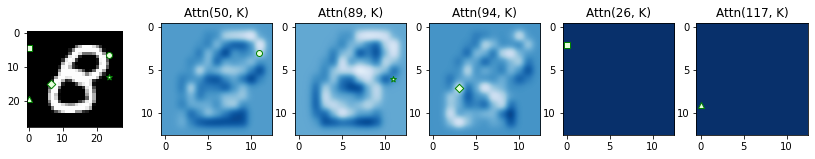

Train on 60000 samples, validate on 10000 samples
938/938 [==============================] - 9s 10ms/step - loss: 0.1915 - accuracy: 0.9423 - val_loss: 0.0517 - val_accuracy: 0.9833


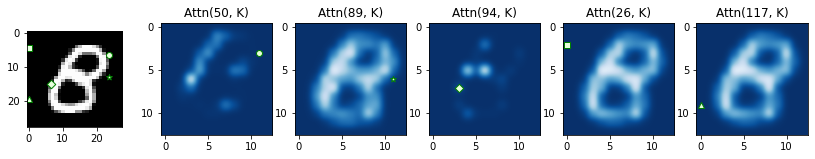

In [25]:
is_MNIST = True
data_set = get_data(is_MNIST)
model = build_model(SelfAttn, is_MNIST=is_MNIST)
x = random_sample(train_images=data_set[0], in_L=data_set[-2], in_c=data_set[-1])
queries = see_attns(x, model, L_atten=2, in_L=data_set[-2], in_c=data_set[-1])
model_trained = train(model, data_set, batch_size=64, epochs=1, verbose=1)
queries = see_attns(x, model_trained, L_atten=2, in_L=data_set[-2], in_c=data_set[-1], queries=queries)

訓練後ではクエリ（緑色、ランダムに表示）に対し、手書き文字の部分的な情報に注意が向いていることがわかります。また、このモデルはアテンションのおかげか、ResBlock構造のおかげかわかりませんが、`epochs` を増やしても検証データの成績が大して悪くならない傾向にあるようで、CIFAR-10などでは一旦良い精度に達した後の精度はBNを入れたとき並みに安定しているように見えます。